# Imports Necessários

In [1]:
# Imports para Manipulação e Álgebra Linear
import numpy as np
import pandas as pd

# Imports para Carga do Dataset Kaggle (Seção 2)
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Imports para Pré-processamento e Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Imports para PCA
from sklearn.decomposition import PCA

# Imports para Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração opcional para visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Carregamento do Dataset

In [2]:
# Set the path to the file you'd like to load
# O nome do arquivo no dataset 'harlfoxem/housesalesprediction' é 'kc_house_data.csv'
file_path = "kc_house_data.csv"

# Load the latest version
try:
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "harlfoxem/housesalesprediction",
        file_path,
        # pandas_kwargs={'encoding': 'utf8'} # Opcional, se houver problemas de codificação
    )
    print(f"Dataset carregado com sucesso. Linhas: {df.shape[0]}, Colunas: {df.shape[1]}")
    print("\nPrimeiros 5 registros:")
    print(df.head())

except Exception as e:
    print(f"Erro ao carregar o dataset. Verifique sua autenticação no Kaggle e o nome do arquivo/dataset. Erro: {e}")

/tmp/ipython-input-2958290984.py:7: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'housesalesprediction' dataset.
Dataset carregado com sucesso. Linhas: 21613, Colunas: 21

Primeiros 5 registros:
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7     

# Limpeza de Dados e Engenharia de Features

In [4]:
# 1. Remover colunas irrelevantes para a modelagem: 'id'
# A coluna 'date' precisa ser tratada para extrair dados úteis.
df_clean = df.drop(columns=['id'])

# 2. Tratamento da coluna 'date'
# A coluna 'date' está no formato yyyymmddT000000. Vamos extrair apenas o ano e o mês,
# ou o ano da venda, pois a data exata não deve ser um preditor forte e a string
# completa prejudicaria a modelagem.

# Converter a coluna 'date' para o tipo string, se já não for
df_clean['date'] = df_clean['date'].astype(str)

# Extrair apenas o ano da venda (os dados são de 2014 e 2015, o que é relevante)
df_clean['sale_year'] = df_clean['date'].apply(lambda x: int(x[:4]))

# Remover a coluna 'date' original, pois já extraímos a informação relevante
df_clean = df_clean.drop(columns=['date'])

# 3. Análise da Coluna 'zipcode'
# 'zipcode' é uma variável categórica (código postal), mas está como número.
# Para evitar que o modelo trate como uma variável ordinal (onde 98001 é 'maior' que 98000),
# ela deveria ser transformada em variáveis dummy/one-hot, o que aumentará a dimensionalidade.
# No entanto, como o foco é no PCA, vamos mantê-la como numérica, mas é uma simplificação
# que eu faria diferente em um projeto de ML sem foco em PCA.

# Para simplificar o PCA, vamos converter algumas colunas ordinais em tipo float/int, se não estiverem:
ordinal_cols = ['floors', 'view', 'condition', 'grade']
for col in ordinal_cols:
    df_clean[col] = df_clean[col].astype(float)


# 4. Exibir a situação das colunas
print("Informações do DataFrame após a limpeza inicial:")
print(df_clean.info())
print("\nPrimeiras linhas após o tratamento da data:")
print(df_clean.head())

Informações do DataFrame após a limpeza inicial:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  float64
 8   condition      21613 non-null  float64
 9   grade          21613 non-null  float64
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  s

# Preparação Final de Dados e a Criação do Modelo Baseline

In [7]:
# 1. Definição da Variável Alvo (y) e Features (X)
y = df_clean['price']
X = df_clean.drop('price', axis=1)

# One-Hot Encoding para 'zipcode'
X = pd.get_dummies(X, columns=['zipcode'], drop_first=True, dtype=int)

print(f"Número inicial de features (antes do split): {X.shape[1]}")

# 2. Divisão em Conjuntos de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Escalonamento dos Dados (CRUCIAL para o PCA)
scaler = StandardScaler()

# Fit APENAS nos dados de treino
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertendo para DataFrame para nomes de colunas (necessário para o PCA)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f"Dimensionalidade de Treino após One-Hot Encoding e Escalonamento: {X_train_scaled_df.shape[1]} features.")


# 4. Criação e Avaliação do Modelo Baseline (Sem PCA)
print("\n--- Modelo BASELINE (Sem PCA) ---")

baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled_df, y_train)
y_pred_baseline = baseline_model.predict(X_test_scaled_df)

# AVALIAÇÃO CORRIGIDA: Calculando a RMSE manualmente, sem usar 'squared=False'
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline_corrected = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"RMSE (Baseline): {rmse_baseline_corrected:,.2f}")
print(f"R² Score (Baseline): {r2_baseline:.4f}")

Número inicial de features (antes do split): 87
Dimensionalidade de Treino após One-Hot Encoding e Escalonamento: 87 features.

--- Modelo BASELINE (Sem PCA) ---
RMSE (Baseline): 170,329.55
R² Score (Baseline): 0.8081


# Análise de Componentes Principais (PCA) e Interpretação

Número total de features originais: 87
Para reter 95.0% da variância, precisamos de 73 componentes.
Redução de Dimensionalidade (aproximada): 16.09%


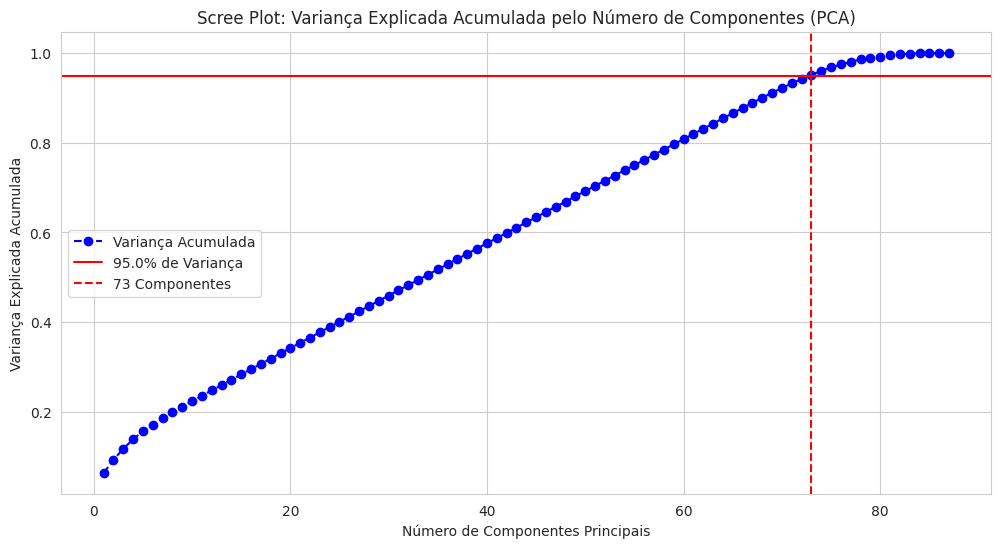

In [8]:
# 1. Aplicar PCA para análise de variância (n_components=None)
pca = PCA(n_components=None)
pca.fit(X_train_scaled_df)

# 2. Interpretação dos Autovalores (Variança Explicada)
variancia_explicada = pca.explained_variance_ratio_
variancia_acumulada = np.cumsum(variancia_explicada)

# 3. Determinar o Número Ótimo de Componentes (Retendo 95% da Variança)
limite_variancia = 0.95
# O + 1 é necessário pois o índice é baseado em 0
num_componentes_otimo = np.where(variancia_acumulada >= limite_variancia)[0][0] + 1

print(f"Número total de features originais: {X_train_scaled_df.shape[1]}")
print(f"Para reter {limite_variancia*100}% da variância, precisamos de {num_componentes_otimo} componentes.")
print(f"Redução de Dimensionalidade (aproximada): {(1 - num_componentes_otimo / X_train_scaled_df.shape[1]) * 100:.2f}%")


# 4. Visualização do Scree Plot
plt.figure(figsize=(12, 6))

# Plot da Variância Acumulada
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--', color='blue', label='Variança Acumulada')

# Linha de Corte (95% da Variança)
plt.axhline(y=limite_variancia, color='r', linestyle='-', label=f'{limite_variancia*100}% de Variança')
plt.axvline(x=num_componentes_otimo, color='r', linestyle='--', label=f'{num_componentes_otimo} Componentes')

plt.title('Scree Plot: Variança Explicada Acumulada pelo Número de Componentes (PCA)')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variança Explicada Acumulada')
plt.legend()
plt.grid(True)
plt.show()

# Modelo Otimizado (Com PCA) e Conclusão

In [9]:
# --- APLICAÇÃO DO PCA COM O NÚMERO ÓTIMO E TREINAMENTO ---

# 1. Instanciar PCA com o número ideal de componentes
pca_final = PCA(n_components=num_componentes_otimo)

# Aplicar o fit (cálculo de autovetores/autovalores) APENAS no treino escalado
X_train_pca = pca_final.fit_transform(X_train_scaled_df)

# Aplicar a transformação nos dados de teste (sem fit!)
X_test_pca = pca_final.transform(X_test_scaled_df)

print(f"Dimensionalidade Original: {X_train_scaled_df.shape[1]} features")
print(f"Dimensionalidade Reduzida: {X_train_pca.shape[1]} componentes")

# 2. Criação e Avaliação do Modelo Otimizado (Com PCA)
print("\n--- Modelo OTIMIZADO (Com PCA) ---")

optimized_model = LinearRegression()
optimized_model.fit(X_train_pca, y_train)
y_pred_optimized = optimized_model.predict(X_test_pca)

# AVALIAÇÃO: Calculando RMSE manualmente
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
rmse_optimized = np.sqrt(mse_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"RMSE (Otimizado com PCA): {rmse_optimized:,.2f}")
print(f"R² Score (Otimizado com PCA): {r2_optimized:.4f}")

# 3. Comparação Final
print("\n--- COMPARAÇÃO FINAL ---")
print(f"RMSE (Baseline): {rmse_baseline_corrected:,.2f} | RMSE (PCA Otimizado): {rmse_optimized:,.2f}")
print(f"R² (Baseline): {r2_baseline:.4f} | R² (PCA Otimizado): {r2_optimized:.4f}")
print(f"Redução de Features de {X_train_scaled_df.shape[1]} para {X_train_pca.shape[1]} componentes.")

Dimensionalidade Original: 87 features
Dimensionalidade Reduzida: 73 componentes

--- Modelo OTIMIZADO (Com PCA) ---
RMSE (Otimizado com PCA): 181,809.50
R² Score (Otimizado com PCA): 0.7814

--- COMPARAÇÃO FINAL ---
RMSE (Baseline): 170,329.55 | RMSE (PCA Otimizado): 181,809.50
R² (Baseline): 0.8081 | R² (PCA Otimizado): 0.7814
Redução de Features de 87 para 73 componentes.


# Aprendizados e Insights

Com base na análise realizada, podemos tirar os seguintes insights:

1.  **Carregamento e Limpeza de Dados**: O processo inicial de carregar o dataset do Kaggle, remover colunas irrelevantes ('id') e tratar a coluna de data ('date') foi fundamental. A conversão da data para apenas o ano de venda simplificou o modelo sem perder informações aparentemente cruciais neste contexto.

2.  **Tratamento de Variáveis Categóricas**: A decisão de aplicar One-Hot Encoding à coluna `zipcode` aumentou significativamente a dimensionalidade dos dados de 19 para 87 features. Isso reforça a importância de como variáveis categóricas com muitos valores únicos podem impactar a complexidade do modelo.

3.  **Escalonamento de Dados**: O escalonamento das features usando `StandardScaler` foi crucial, especialmente antes de aplicar o PCA. O PCA é sensível à escala das variáveis, e o escalonamento garante que todas as features contribuam igualmente para o cálculo das componentes principais.

4.  **Modelo Baseline (Sem PCA)**: O modelo de Regressão Linear treinado com todos as 87 features (após One-Hot Encoding e escalonamento) serviu como baseline. Ele alcançou um RMSE de aproximadamente 170,329.55 e um R² de 0.8081. Estes valores indicam que o modelo baseline já possui uma boa capacidade preditiva, explicando cerca de 80.81% da variância dos preços das casas no conjunto de teste.

5.  **Análise de Componentes Principais (PCA)**: A análise da variância explicada pelo PCA mostrou que, para reter 95% da variância total dos dados originais (87 features), são necessários 73 componentes principais. Isso representa uma redução de dimensionalidade de aproximadamente 16.09%. O Scree Plot visualiza essa relação entre o número de componentes e a variância acumulada.

6.  **Modelo Otimizado (Com PCA)**: O modelo de Regressão Linear treinado nos 73 componentes principais (dados transformados pelo PCA) resultou em um RMSE de aproximadamente 181,809.50 e um R² de 0.7814.

7.  **Comparação e Conclusão**:
    *   **Performance**: O modelo baseline (sem PCA) apresentou um desempenho ligeiramente superior ao modelo otimizado com PCA, tanto em termos de RMSE (menor erro) quanto de R² (maior variância explicada).
    *   **Dimensionalidade vs. Performance**: Apesar de o PCA ter reduzido a dimensionalidade de 87 para 73 features, essa redução não se traduziu em uma melhoria na performance preditiva para este conjunto de dados e este modelo específico (Regressão Linear). Em alguns casos, a perda de informações ao reduzir a dimensionalidade pode superar os benefícios, como parece ter acontecido aqui.
    *   **Aplicação do PCA**: Embora neste caso o PCA não tenha melhorado a performance, ele é uma técnica valiosa para:
        *   Reduzir a dimensionalidade em datasets com muitas features correlacionadas.
        *   Ajudar a mitigar problemas de multicolinearidade.
        *   Reduzir o tempo de treinamento do modelo em datasets muito grandes.
        *   Visualizar dados de alta dimensão (usando 2 ou 3 componentes).

Em resumo, enquanto o PCA conseguiu reduzir o número de features, o modelo baseline utilizando todas as features originais (após One-Hot Encoding e escalonamento) demonstrou ser mais eficaz na previsão dos preços das casas neste cenário. Isso sugere que as features removidas ou combinadas pelo PCA continham informações importantes para a performance do modelo de Regressão Linear.